# SAN FRANSISCO CRIME CLASSIFICATION
Predict the category of crimes that occurred in the city by the bay

#### Description
From 1934 to 1963, San Francisco was infamous for housing some of the world's most notorious criminals on the inescapable island of Alcatraz.

Today, the city is known more for its tech scene than its criminal past. But, with rising wealth inequality, housing shortages, and a proliferation of expensive digital toys riding BART to work, there is no scarcity of crime in the city by the bay.

From Sunset to SOMA, and Marina to Excelsior, this dataset provides nearly 12 years of crime reports from across all of San Francisco's neighborhoods. Given time and location, you must predict the category of crime that occurred.

#### Evaluation
Submissions are evaluated using the multi-class logarithmic loss. Each incident has been labeled with one true class. For each incident, you must submit a set of predicted probabilities (one for every class). The formula is then,
$log loss = -\frac{1}{N}\sum_{i=1}^N\sum_{j=1}^My_{ij}\log(p_{ij})$

where N is the number of cases in the test set, M is the number of class labels, \\(log\\) is the natural logarithm, \\(y_{ij}\\) is 1 if observation \\(i\\) is in class \\(j\\) and 0 otherwise, and \\(p_{ij}\\) is the predicted probability that observation \\(i\\) belongs to class \\(j\\).

#### Citation
Wendy Kan. San Francisco Crime Classification. https://kaggle.com/competitions/sf-crime, 2015. Kaggle.

---
## LIBRARIES AND DATA IMPORT

In [ ]:
# !pip install pydeck
# !pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 58.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 6.7 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.feature_selection import f_classif, chi2
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from sklearn.calibration import CalibratedClassifierCV

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from geopy.distance import geodesic
import pydeck as pdk
import ipywidgets as widgets
from IPython.display import IFrame
import joblib
import os
from glob import glob

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data = pd.read_csv('train.csv')
data

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541
...,...,...,...,...,...,...,...,...,...
878044,2003-01-06 00:15:00,ROBBERY,ROBBERY ON THE STREET WITH A GUN,Monday,TARAVAL,NONE,FARALLONES ST / CAPITOL AV,-122.459033,37.714056
878045,2003-01-06 00:01:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Monday,INGLESIDE,NONE,600 Block of EDNA ST,-122.447364,37.731948
878046,2003-01-06 00:01:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Monday,SOUTHERN,NONE,5TH ST / FOLSOM ST,-122.403390,37.780266
878047,2003-01-06 00:01:00,VANDALISM,"MALICIOUS MISCHIEF, VANDALISM OF VEHICLES",Monday,SOUTHERN,NONE,TOWNSEND ST / 2ND ST,-122.390531,37.780607


---
## EXPLORATORY DATA ANALYSIS

In [4]:
data.isnull().sum()

Dates         0
Category      0
Descript      0
DayOfWeek     0
PdDistrict    0
Resolution    0
Address       0
X             0
Y             0
dtype: int64

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878049 entries, 0 to 878048
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Dates       878049 non-null  object 
 1   Category    878049 non-null  object 
 2   Descript    878049 non-null  object 
 3   DayOfWeek   878049 non-null  object 
 4   PdDistrict  878049 non-null  object 
 5   Resolution  878049 non-null  object 
 6   Address     878049 non-null  object 
 7   X           878049 non-null  float64
 8   Y           878049 non-null  float64
dtypes: float64(2), object(7)
memory usage: 60.3+ MB


REMARKS: Here we can see that there's no null data. But majority of the data is in categorical type, which we will encode them later. We'll also breakdown the date into separate columns, so we will have Date, Month and Year. We'll also break the hours into bins, so crime at 12-1AM will be at bin 0, 1-2AM will be at bin 1 and so on. We'll also drop 'Descript','Resolution' columns because the Description only describe the category crime which in the end the same with the category anyways, and Resolution is the actions that have been done to solve the crime and doesn't reflect how to predict it in the first place.

In [6]:
data['Dates'] = pd.to_datetime(data['Dates'])

# Extract components
data['Year'] = data['Dates'].dt.year
data['Month'] = data['Dates'].dt.month
data['Day'] = data['Dates'].dt.day
data['Hour'] = data['Dates'].dt.hour
data['Minute'] = data['Dates'].dt.minute
data['Second'] = data['Dates'].dt.second

# Create time bin (1 to 24, for each hour)
data['Hour_Bin'] = data['Hour'] + 1

# Optional: drop original datetime if not needed
data = data.drop(columns=['Dates', 'Hour', 'Minute', 'Second'])
data

,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,Year,Month,Day,Hour_Bin
0,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,2015,5,13,24
1,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,2015,5,13,24
2,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414,2015,5,13,24
3,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873,2015,5,13,24
4,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541,2015,5,13,24
...,...,...,...,...,...,...,...,...,...,...,...,...
878044,ROBBERY,ROBBERY ON THE STREET WITH A GUN,Monday,TARAVAL,NONE,FARALLONES ST / CAPITOL AV,-122.459033,37.714056,2003,1,6,1
878045,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Monday,INGLESIDE,NONE,600 Block of EDNA ST,-122.447364,37.731948,2003,1,6,1
878046,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Monday,SOUTHERN,NONE,5TH ST / FOLSOM ST,-122.403390,37.780266,2003,1,6,1
878047,VANDALISM,"MALICIOUS MISCHIEF, VANDALISM OF VEHICLES",Monday,SOUTHERN,NONE,TOWNSEND ST / 2ND ST,-122.390531,37.780607,2003,1,6,1


In [7]:
data.drop(columns=['Descript','Resolution'], inplace=True)
data

,Category,DayOfWeek,PdDistrict,Address,X,Y,Year,Month,Day,Hour_Bin
0,WARRANTS,Wednesday,NORTHERN,OAK ST / LAGUNA ST,-122.425892,37.774599,2015,5,13,24
1,OTHER OFFENSES,Wednesday,NORTHERN,OAK ST / LAGUNA ST,-122.425892,37.774599,2015,5,13,24
2,OTHER OFFENSES,Wednesday,NORTHERN,VANNESS AV / GREENWICH ST,-122.424363,37.800414,2015,5,13,24
3,LARCENY/THEFT,Wednesday,NORTHERN,1500 Block of LOMBARD ST,-122.426995,37.800873,2015,5,13,24
4,LARCENY/THEFT,Wednesday,PARK,100 Block of BRODERICK ST,-122.438738,37.771541,2015,5,13,24
...,...,...,...,...,...,...,...,...,...,...
878044,ROBBERY,Monday,TARAVAL,FARALLONES ST / CAPITOL AV,-122.459033,37.714056,2003,1,6,1
878045,LARCENY/THEFT,Monday,INGLESIDE,600 Block of EDNA ST,-122.447364,37.731948,2003,1,6,1
878046,LARCENY/THEFT,Monday,SOUTHERN,5TH ST / FOLSOM ST,-122.403390,37.780266,2003,1,6,1
878047,VANDALISM,Monday,SOUTHERN,TOWNSEND ST / 2ND ST,-122.390531,37.780607,2003,1,6,1


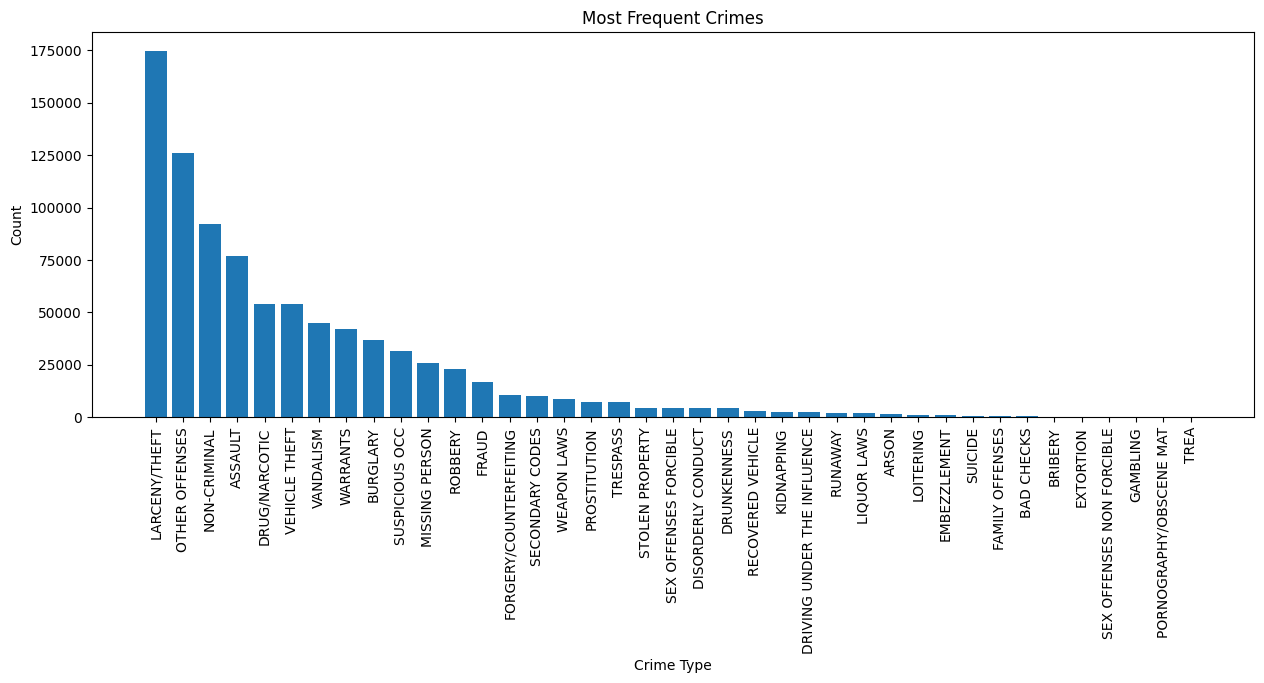

In [8]:
a = data.groupby('Category')['Category'].count().sort_values(ascending=False)
b = data.groupby('DayOfWeek')['DayOfWeek'].count().sort_values(ascending=False)
c = data.groupby('PdDistrict')['PdDistrict'].count().sort_values(ascending=False)

plt.figure(figsize=(15, 5))
plt.bar(x=a.index, height=a.values)
plt.title('Most Frequent Crimes')
plt.xlabel('Crime Type')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

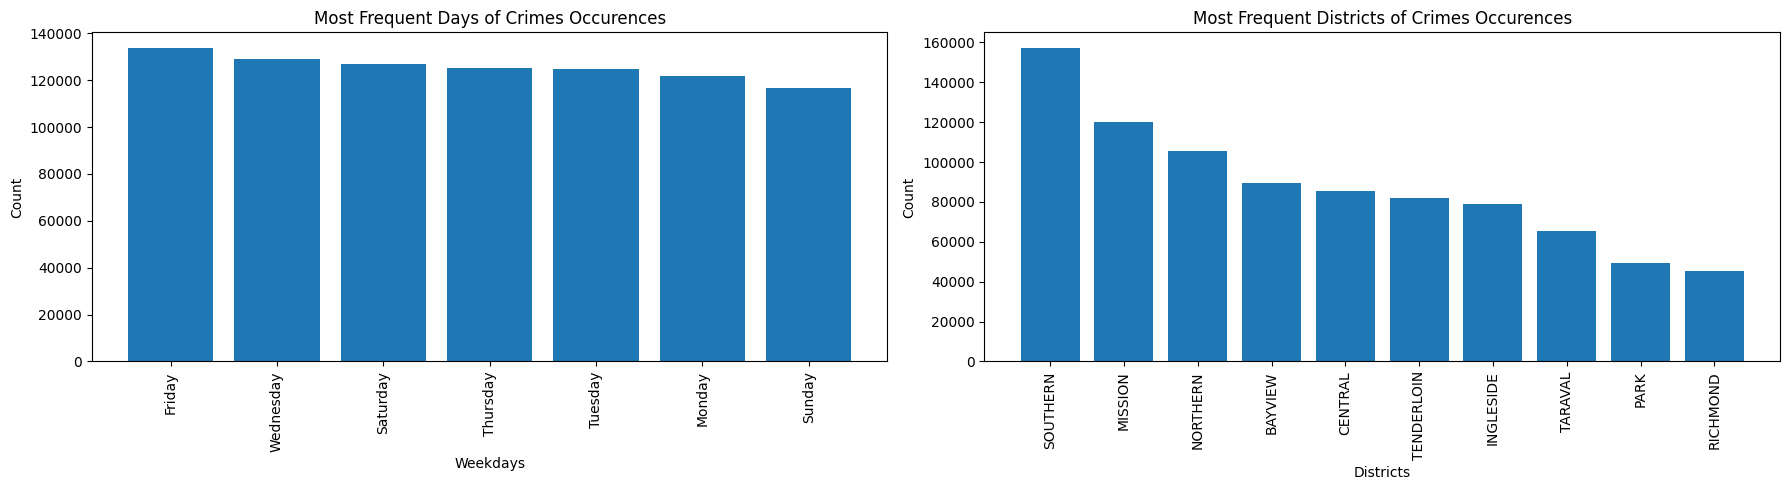

In [ ]:
plt.figure(figsize=(18, 5))
plt.subplot(121)
plt.bar(x=b.index, height=b.values)
plt.title('Most Frequent Days of Crimes Occurences')
plt.xlabel('Weekdays')
plt.ylabel('Count')
plt.xticks(rotation=90)

plt.subplot(122)
plt.bar(x=c.index, height=c.values)
plt.title('Most Frequent Districts of Crimes Occurences')
plt.xlabel('Districts')
plt.ylabel('Count')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

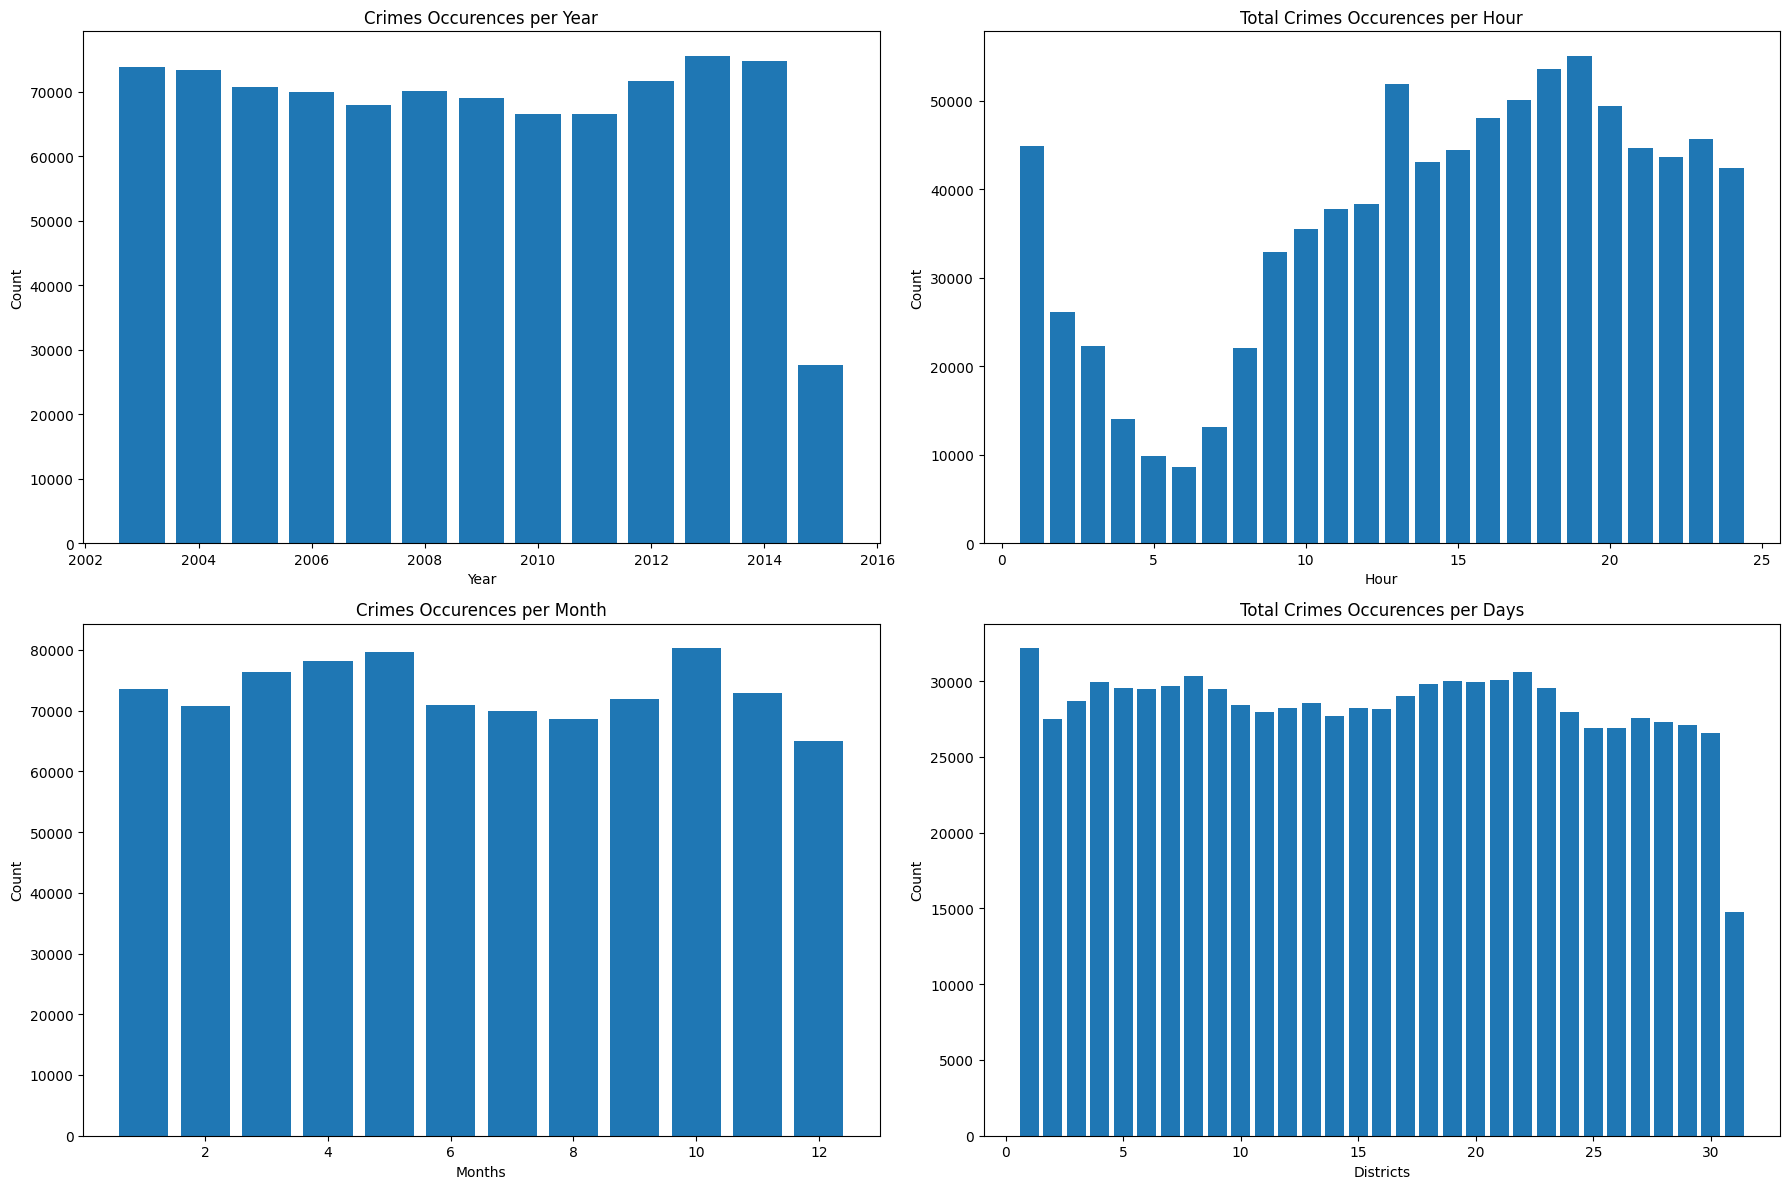

In [9]:
d = data.groupby('Year')['Year'].count().sort_values(ascending=False)
e = data.groupby('Hour_Bin')['Hour_Bin'].count().sort_values(ascending=False)
f = data.groupby('Month')['Month'].count().sort_values(ascending=False)
g = data.groupby('Day')['Day'].count().sort_values(ascending=False)

plt.figure(figsize=(18, 12))
plt.subplot(221)
plt.bar(x=d.index, height=d.values)
plt.title('Crimes Occurences per Year')
plt.xlabel('Year')
plt.ylabel('Count')

plt.subplot(222)
plt.bar(x=e.index, height=e.values)
plt.title('Total Crimes Occurences per Hour')
plt.xlabel('Hour')
plt.ylabel('Count')

plt.subplot(223)
plt.bar(x=f.index, height=f.values)
plt.title('Crimes Occurences per Month')
plt.xlabel('Months')
plt.ylabel('Count')

plt.subplot(224)
plt.bar(x=g.index, height=g.values)
plt.title('Total Crimes Occurences per Days')
plt.xlabel('Districts')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

In [10]:
data['date_str'] = pd.to_datetime(data[['Year', 'Month', 'Day']]).dt.strftime('%Y-%m-%d')

# Build UI widgets
category_dropdown = widgets.Dropdown(
    options=sorted(data['Category'].unique()),
    description='Category:',
    value=data['Category'].iloc[0]
)

date_slider = widgets.SelectionSlider(
    options=sorted(data['date_str'].unique()),
    description='Date:',
    value=sorted(data['date_str'].unique())[0],
    continuous_update=False
)

# Update function for interactivity
def update_map(category, date_str):
    filtered = data[(data['Category'] == category) & (data['date_str'] == date_str)]

    layer = pdk.Layer(
        "HeatmapLayer",
        filtered,
        get_position='[X, Y]',
        aggregation='MEAN',
        get_weight=1,
        radiusPixels=50,
    )

    view_state = pdk.ViewState(
        latitude=filtered['Y'].mean() if not filtered.empty else -6.2,
        longitude=filtered['X'].mean() if not filtered.empty else 106.8,
        zoom=11,
        pitch=50
    )

    deck = pdk.Deck(
        layers=[layer],
        initial_view_state=view_state,
        tooltip={"text": f"{category} - {date_str}"}
    )

    return deck.show()

# Display interactive UI
widgets.interact(update_map, category=category_dropdown, date_str=date_slider)

interactive(children=(Dropdown(description='Category:', index=37, options=('ARSON', 'ASSAULT', 'BAD CHECKS', '…

<function __main__.update_map(category, date_str)>

REMEARKS: Based on the visualization above we can see that LARCENY/THEFT, OTHER OFFENSES, NON-CRIMINAL, ASSAULT, DRUG and VEHICLE THEFT. The crime also prone to be much more happening in Friday and district SOUTHERN, MISSION, and NORTHERN having more criminals occurences.

It was also observed that in the year 2010-2011 the number of crime occurences are lower than other year and year 2013 having frequent crime occurences. The data for the year 2015 are still incomplete, and therefore we can see low data input in this year.

The crime rate also happens to be lower in the morning around 5-7 AM and higher in the evening around 5-7 PM. If we observed the crime rate in terms of Monthly occurances, we can see that the crime rates are high in May and October, and tends to be higher in the early weeks.

THe hatmap also shows us that in one particular place, two or more crime can be happening although not in the same time. This will pose tough challenges for the classifier model to predict. We can also see that the occurences are clustered quite close to the downtown San Fransisco, this indicates low occurences of outliers. Nevertheless, we shall still check the outliers before modelling the Machine Learning.

---
## PRE-PROCESSING STAGE

Due to unique patterns more than 2 crimes can happen in one place, we'll use strong Machine Learning model such as `RandomForestClassifier`, `LightGradientBoostingMachine` and `CatBoostClassifier` for this task. If we want to use `RandomForestClassifier` or `LightGradientBoostingMachine` then we must encode some of the categorical features, however if later we found that `CatBoost` is much more adventageous, then we don't need the encoding step.

We'll also do Feature Engineering to cluster the coordinates and Frequency-Encoding technique for the address.

In [ ]:
# CONVERT THE DAY OF WEEK TO LABEL ENCODING
data.drop(columns='date_str', inplace=True)
# le = LabelEncoder()
# data['DayOfWeek'] = le.fit_transform(data['DayOfWeek'])
# data['Category'] = le.fit_transform(data['Category'])

# data = pd.get_dummies(data, columns=['PdDistrict'])
# data

# USING RANDOM FOREST CLASSIFIER OR LGBM CLASSIFIER IS NAT AS GOOD AS USING CATBOOST
# AND THEREFORE ENCODING IS NOT NECESSARY IF WE'RE USING CATBOOST

In [ ]:
# USING KMEANS TO CLUSTER UP ADDRESS AND COORDINATES

data['address_freq'] = data['Address'].map(data['Address'].value_counts())

# Coordinate clustering
coords = data[['Y', 'X']]
kmeans = KMeans(n_clusters=300, random_state=42)
data['location_cluster'] = kmeans.fit_predict(coords)

# Distance to city center
city_center = (data['Y'].mean(), data['X'].mean())
data['dist_to_center'] = data.apply(lambda row: geodesic((row['Y'], row['X']), city_center).meters, axis=1)
data


,Category,DayOfWeek,PdDistrict,Address,X,Y,Year,Month,Day,Hour_Bin,address_freq,location_cluster,dist_to_center
0,WARRANTS,Wednesday,NORTHERN,OAK ST / LAGUNA ST,-122.425892,37.774599,2015,5,13,24,45,112,490.920543
1,OTHER OFFENSES,Wednesday,NORTHERN,OAK ST / LAGUNA ST,-122.425892,37.774599,2015,5,13,24,45,112,490.920543
2,OTHER OFFENSES,Wednesday,NORTHERN,VANNESS AV / GREENWICH ST,-122.424363,37.800414,2015,5,13,24,23,145,3266.139574
3,LARCENY/THEFT,Wednesday,NORTHERN,1500 Block of LOMBARD ST,-122.426995,37.800873,2015,5,13,24,155,145,3335.759248
4,LARCENY/THEFT,Wednesday,PARK,100 Block of BRODERICK ST,-122.438738,37.771541,2015,5,13,24,52,16,1421.524327
...,...,...,...,...,...,...,...,...,...,...,...,...,...
878044,ROBBERY,Monday,TARAVAL,FARALLONES ST / CAPITOL AV,-122.459033,37.714056,2003,1,6,1,25,208,7090.601910
878045,LARCENY/THEFT,Monday,INGLESIDE,600 Block of EDNA ST,-122.447364,37.731948,2003,1,6,1,6,143,4854.254254
878046,LARCENY/THEFT,Monday,SOUTHERN,5TH ST / FOLSOM ST,-122.403390,37.780266,2003,1,6,1,174,291,1980.397189
878047,VANDALISM,Monday,SOUTHERN,TOWNSEND ST / 2ND ST,-122.390531,37.780607,2003,1,6,1,77,173,3020.308418


In [ ]:
# numeric_features = ['Year', 'Month', 'Day', 'Hour_Bin', 'DayOfWeek',
#                     'address_freq', 'location_cluster', 'dist_to_center']
# X = data[numeric_features]

# # Fit IsolationForest
# iso = IsolationForest(contamination=0.05, random_state=42)
# outliers = iso.fit_predict(X)

# # -1 = outlier, 1 = inlier
# data = data[outliers == 1]

# print(f"Removed {(outliers == -1).sum()} outliers. Remaining samples: {data.shape[0]}")

# LATER IT WAS OBSERVED THAT DELETING OUTLIERS IN GROUP LIKE THIS WILL HAVE DETRIMENTAL EFFECT
# ON THE MACHINE LEARNING MODEL PERFORMANCE

Since we have multclass target feature, it's not practila to have correlation study with Pearson's, Spearman's or other traditional methods. Therefore we will do ANOVA test between numerical features and target features. If the p-value was low (below 0.05) then the features have good contribution to predict the target feature. For one-hot encoded features, we will do chi-square test for the same purposes.

In [ ]:
# Select numeric features
X_num = data[['Year', 'Month', 'Day', 'Hour_Bin', 'address_freq', 'location_cluster', 'dist_to_center']]
y = data['Category']

# Run ANOVA F-test
f_vals, p_vals = f_classif(X_num, y)

# Display results
anova_result = pd.DataFrame({
    'Feature': X_num.columns,
    'F-Value': f_vals,
    'p-Value': p_vals
}).sort_values(by='F-Value', ascending=False)

print(anova_result)

            Feature     F-Value        p-Value
0              Year  481.656254   0.000000e+00
3          Hour_Bin  377.271548   0.000000e+00
4      address_freq  239.722506   0.000000e+00
5  location_cluster   56.362109   0.000000e+00
1             Month   18.447459  7.154979e-123
2               Day   17.338905  3.252899e-114
6    dist_to_center    2.315233   7.730934e-06


In [ ]:
# X_cat = data.filter(like='PdDistrict_').astype(int)  # Convert True/False to 1/0
# y = data['Category']

# # Run chi-squared test
# chi_vals, chi_pvals = chi2(X_cat, y)

# chi_result = pd.DataFrame({
#     'Feature': X_cat.columns,
#     'Chi2-Score': chi_vals,
#     'p-Value': chi_pvals
# }).sort_values(by='Chi2-Score', ascending=False)

# print(chi_result)

# DUE TO CATBOOST CLASSIFIER USAGE, ONE-HOT ENCODING IS NOT NECESSARY ANYMORE, AND THEREFORE
# CHI SQUARE TEST CAN BE AMMENDED

---
## MACHINE LEARNING MODELLING

We will use 3 models namely `RandomForestClassifier`, `LightGradientBoostingMachine` and `CatBoostClassifier` to predict the dataset and then we will wrap the best model with `CalibratedClassifierCV`. `CalibratedClassifierCV` from scikit-learn is used to improve the probability estimates of a classifier. While many classifiers output probabilities (e.g. predict_proba()), these probabilities are often not well calibrated, meaning they don't reflect true likelihoods. Calibration aligns the predicted probabilities with the actual frequencies observed in the data.

In [ ]:
datrain, datest = train_test_split(data, test_size=0.2, random_state=42)

WARNING: IF YOU WANT TO RUN CATBOOST MAKE SURE YOU HAVE AT LEAST 8 GB STORAGE, BECAUSE IF WE HAVE TO RUN THE MODEL IN ONE GO THEN THE RAM USAGE WILL BE EXTREMELY HIGH. THEREFORE I WROTE AN ALGORITHM TO SAVE THE MODELS AFTER IT LEARNS 5 CATEGORIES AND THEN GIVE TIME FOR USER TO RESTART THE KERNEL AND DO THE LEARNING STEP AGAIN UNTILL ALL CATEGORIS ARE COVERED. MAKE SURE YOU ALSO HAVE ENOUGH RAM (10-16GB)

In [ ]:
data_s = datrain.copy()
os.makedirs("models/", exist_ok=True)
batch_size = 5
models = {}
log_loss_result = []
classes = sorted(data_s['Category'].unique())
categorical_columns = ['DayOfWeek','PdDistrict','Address']
start_from = 0

for i, cls in enumerate(classes[start_from:], start=start_from):
# for i, cls in enumerate(classes):
    # 1-vs-rest labels
    print(f"\nTraining classifier for class {cls} ({i+1}/39)")
    y_bin = (data_s['Category'] == cls).astype(int)
    x_mod = data_s.drop(columns='Category')

    # Train model
    x_train, x_test, y_train, y_test = train_test_split(x_mod, y_bin, test_size=0.2, random_state=42)
    # mod_clf = LGBMClassifier(n_estimators=150, max_depth=30, random_state=42, verbosity=1)
    # mod_clf = RandomForestClassifier(n_estimators=150, max_depth=30, random_state=42, verbosity=1)
    mod_clf = CatBoostClassifier(
        iterations=200,
        learning_rate=0.05,
        depth=6,
        loss_function='Logloss',
        eval_metric='Logloss',
        cat_features=categorical_columns,  # Pass raw categorical features here
        verbose=True,
        random_seed=42
    )
    mod_clf.fit(x_train, y_train)
    # y_pred_proba = mod_clf.predict_proba(x_test)

    if y_train.sum() < 5 or (y_train == 0).sum() < 5:
      # Too small — use prefit
      calibrated_model = CalibratedClassifierCV(mod_clf, cv='prefit', method='sigmoid')
      calibrated_model.fit(x_train, y_train)  # Calibrates only
    else:
      # Normal case — let calibrator handle fitting + CV
      calibrated_model = CalibratedClassifierCV(mod_clf, cv=5, method='sigmoid')
      calibrated_model.fit(x_train, y_train)

    y_pred_proba = calibrated_model.predict_proba(x_test)
    loss = log_loss(y_test, y_pred_proba)
    print(f"Log Loss-{cls}: {loss:.5f}")

    # Store in dict
    models[cls] = calibrated_model
    log_loss_result.append(loss)

    # Save every batch_size models
    if (i - start_from + 1) % batch_size == 0 or cls == classes[-1]:
    # if (i + 1) % batch_size == 0 or cls == classes[-1]:
        batch_num = (i - start_from) // batch_size + 1
        file_name = f"models/model_batch_{batch_num}.pkl"
        joblib.dump(models, file_name)
        print(f"Saved batch {batch_num} to {file_name}")
        print("\nSaving batch completed.")
        print("To continue, re-run this cell and input starting index:", i + 1)
        break  # Stop after this batch

In [ ]:
class_to_index = {label: idx for idx, label in enumerate(sorted(datest['Category'].unique()))}

In [ ]:
datest_valid = datest.drop(columns='Category')
# Initialize prediction matrix
n_classes = 39
n_samples = datest_valid.shape[0]
proba_matrix = np.zeros((n_samples, n_classes))

# Load all model files
model_files = sorted(glob("models/model_batch_*.pkl"))

# Loop through model files
for file_path in model_files:
    models = joblib.load(file_path)

    for cls_label, model in models.items():
        # class_index = int(cls_label)
        class_index = class_to_index[cls_label]
        prob = model.predict_proba(datest_valid)[:, 1]  # take only positive class probability
        proba_matrix[:, class_index] = prob

# Row-wise normalization (sum of probs = 1 for each sample)
proba_matrix /= proba_matrix.sum(axis=1, keepdims=True)

print("Multiclass probability matrix shape:", proba_matrix.shape)
submission = pd.DataFrame(proba_matrix, columns=[f"{i}" for i in range(0, 39)])
submission.to_csv("submission.csv", index=False)
submission

Multiclass probability matrix shape: (175610, 39)


,0,1,2,3,4,5,6,7,8,9,...,29,30,31,32,33,34,35,36,37,38
0,0.001615,0.053413,0.000349,0.000321,0.023638,0.004313,0.002355,0.028974,0.006106,0.001202,...,0.000152,0.004579,0.000558,0.027504,0.000003,0.008047,0.028704,0.028289,0.075777,0.008188
1,0.001996,0.120533,0.000472,0.000395,0.029528,0.005338,0.002778,0.033419,0.007109,0.001431,...,0.000198,0.004933,0.000692,0.028057,0.000004,0.008849,0.046017,0.047417,0.038617,0.010413
2,0.001381,0.041221,0.000288,0.000271,0.020165,0.003444,0.002023,0.022426,0.004010,0.001010,...,0.000123,0.004577,0.000474,0.025493,0.000003,0.006023,0.043907,0.028222,0.021685,0.006567
3,0.001713,0.065786,0.000378,0.000339,0.022979,0.004407,0.002725,0.032233,0.004664,0.001243,...,0.000162,0.004699,0.000594,0.022481,0.000004,0.007323,0.076603,0.049106,0.034027,0.013302
4,0.001699,0.056705,0.000385,0.000335,0.048813,0.004360,0.002389,0.028456,0.004462,0.001290,...,0.000158,0.005818,0.000592,0.039301,0.000004,0.007858,0.040583,0.063212,0.030490,0.007878
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175605,0.001910,0.093304,0.000469,0.000376,0.039093,0.004829,0.002463,0.031890,0.004906,0.001397,...,0.000180,0.008214,0.000661,0.038245,0.000004,0.008424,0.039492,0.045167,0.034258,0.008886
175606,0.001432,0.078036,0.000345,0.000276,0.019526,0.029731,0.002767,0.024670,0.004655,0.000965,...,0.000148,0.004347,0.000471,0.029661,0.000003,0.005930,0.044657,0.027102,0.033272,0.008105
175607,0.001458,0.048220,0.000415,0.000288,0.027348,0.003705,0.001903,0.023348,0.003725,0.001174,...,0.000135,0.005329,0.000507,0.085348,0.000004,0.008360,0.031018,0.027166,0.024472,0.006785
175608,0.001555,0.075724,0.000366,0.000344,0.022266,0.003962,0.001951,0.026354,0.003871,0.001179,...,0.000158,0.005053,0.000539,0.029679,0.000004,0.007142,0.028045,0.028088,0.027998,0.008844


In [ ]:
y_true = datest['Category']

log_loss_value = log_loss(y_true, proba_matrix)
print(f"Multiclass Log Loss: {log_loss_value:.5f}")

Multiclass Log Loss: 2.37344


COMMENTS: This model doesn't try to guess crime like flipping a coin. It works more like a weather forecast.

For example, if a weather app tells you there's an 80% chance of rain, it's not claiming rain is certain — just very likely. That's exactly how this crime prediction model works.

Instead of saying "a burglary will definitely happen", it says:
"Given this place and time, there's a 42% chance of burglary, 30% chance of assault, and 12% chance of drug-related crime."

And when we evaluated it against historical data, this model's forecasts were 10x more accurate than random chance. Because if we have to do random guessing then the approximate log-loss was about 3.66, while this model score 2.37.